In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table

In [2]:
import sklearn
print(sklearn.__version__)

0.23.0


In [3]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [4]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [5]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path
from kndetect.features import extract_features_all_lightcurves
from kndetect.training import append_y_true_col

In [6]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [7]:
use_already_trained_features = True
use_already_trained_models = True
mimic_alerts = True
save_data = False

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"

In [8]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"),index_col=0)

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [9]:
train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred,y_score
0,0.632028,0.008088,0.366976,0.958710,230.670456,0.727304,-0.098875,0.355660,1.610522,373.748047,1757,57661.2736,150,150: KN GW170817,True,True,0.754450
1,0.782480,0.268593,0.149629,0.466376,427.853790,1.060051,-0.059434,-0.106277,1.989556,788.683228,6415,57461.4561,141,141: 91BG,False,False,0.000926
2,0.750644,0.087323,0.172727,0.937126,270.629425,0.876449,0.080352,0.104214,0.825639,401.693390,7707,57484.2005,103,103: Core collapse Type Ibc,False,False,0.048600
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.712076,0.151259,0.263020,1.071781,534.019775,8267,57671.3147,151,151: KN Karsen 2017,True,False,0.252970
4,1.028029,-0.020704,0.038843,0.993747,263.286224,0.000000,0.000000,0.000000,0.000000,0.000000,12578,57517.4403,102,102: MOSFIT-Ibc,False,False,0.082412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22275,1.088962,-0.014523,0.106654,1.693484,888.318420,1.205512,-0.059662,0.725981,1.578576,666.974243,137062467,57565.3666,112,112: Core collapse Type II,False,False,0.000000
22276,0.978098,-0.118905,-0.022548,1.571079,1141.677979,1.038589,-0.084343,0.017370,1.344228,1213.934937,137071784,57690.5287,170,170: AGN,False,False,0.000000
22277,1.038554,-0.092552,0.148199,1.327237,295.870941,0.990183,-0.038269,0.027255,0.717529,408.148193,137071978,57621.3001,143,143: Iax,False,False,0.000618
22278,0.622255,-0.028716,0.439814,1.676503,525.301697,0.000000,0.000000,0.000000,0.000000,0.000000,137079473,57493.3158,151,151: KN Karsen 2017,True,True,0.668448


# Now Train the classifier

In [10]:
from kndetect.training import train_classifier

In [11]:
if not use_already_trained_models:
    clf, features_df = train_classifier(train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    from kndetect.predict import load_classifier
    clf = load_classifier(sub_directory + ".pkl")

In [12]:
# Generate Test features and Predict probabilities

In [13]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [14]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [15]:
from kndetect.predict import load_classifier, predict_kn_score

In [16]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)

In [17]:
test_features_df['y_pred_score'] = probabilities.T[1]

In [18]:
filtered=test_features_df[filtered_indices]

In [19]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_pred_score"]>0.5

In [20]:
print("True Positive : {tp}".format(tp = np.sum(y_true&y_pred)))
print("False Positive : {fp}".format(fp = np.sum(~y_true&y_pred)))
print("True negative : {tn}".format(tn = np.sum(~y_true&~y_pred)))
print("False negative : {fn}".format(fn = np.sum(y_true&~y_pred)))

True Positive : 760
False Positive : 391
True negative : 13463
False negative : 362


In [21]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

In [22]:
from kndetect.plot_lightcurve import plot_contamination_statistics

In [29]:
test_features_df = test_features_df[~((test_features_df["coeff1_r"] == 0) | (test_features_df["coeff1_g"] == 0))]

In [30]:
test_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred_score
1,1.278121,-0.408748,0.029594,1.286949,1002.060974,1.306093,-0.348116,0.042639,1.875026,1348.136475,10871,57654.4388,162,162: ILOT,False,0.000000
3,0.375809,0.246783,-0.667758,13.745609,2329.209717,0.164850,0.096115,0.144858,12.132693,1588.494263,11422,57668.3382,180,180: RRLyrae,False,0.073406
4,0.209124,0.223297,0.556692,33.571213,9754.292969,0.234587,0.423794,0.402900,15.863667,3541.758301,13390,57454.4268,180,180: RRLyrae,False,0.000000
5,0.735866,-0.130123,0.334619,1.005109,229.550552,0.697319,-0.029899,0.326297,1.574266,376.082275,13997,57490.4643,150,150: KN GW170817,True,0.699677
6,0.892691,0.201483,-0.013716,0.642264,593.578918,1.052192,0.012164,0.012969,0.541442,567.627747,15596,57532.4743,145,145: point Ia,False,0.040284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21280,0.849968,0.000615,0.241144,1.088922,442.724091,1.137844,-0.073947,-0.042236,0.704835,1083.786621,137034960,57544.4661,141,141: 91BG,False,0.000000
21282,1.133835,0.059827,0.025865,1.829785,918.226074,1.063157,-0.016905,-0.007959,0.684157,1070.560547,137044385,57538.4761,163,163: CART,False,0.002408
21283,0.871747,0.627985,0.575338,3.921973,1325.314697,1.181615,-0.166189,0.313255,1.544002,1154.043457,137049400,57561.2518,183,183: PHOEBE,False,0.033333
21284,0.564151,-0.070066,0.451263,1.726883,229.678802,0.257282,0.131209,0.034074,2.932202,785.573853,137051059,57641.4133,181,M 181: dwarf_flares,False,0.553502


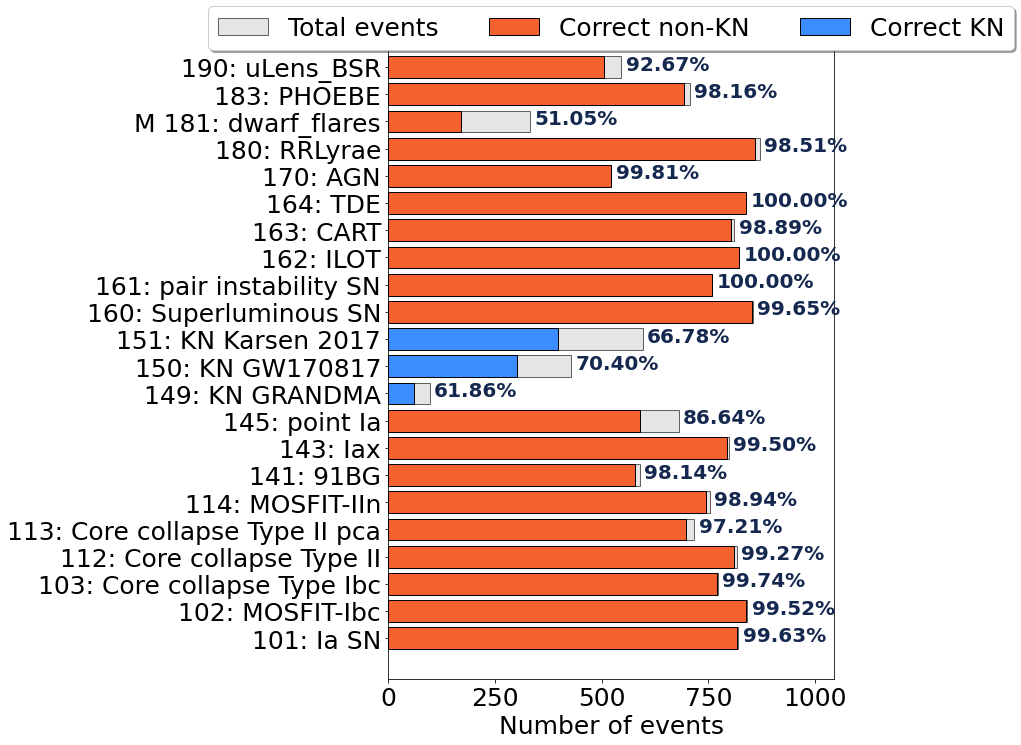

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,12))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151])